# Cat Dog Images Classification - Deep CNN, K-Means

# Theory Review

## 1.1 K-means Clustering
- K-Means Clustering in TEFPA framework and reasons why it belong to "Unsupervised Learning" type of Machine Learning algorithm

- Clustering with K-means algorithm
  - Task: $D=\{\mathbf{x}_t\}_{t=1}^N\overset{f}{\to}$ $K$ cluster centroids $\{\mathbf{x}^c_i\}_{i=1}^K$ + nearest centroid assignments.
  - Experience: only inputs $D=\{\mathbf{x}_t\}_{t=1}^N$; no labels hence *unsupervised learning*.
  - Function space: distance functions, i.e., Euclidean distance $d(\mathbf{x}_t,\mathbf{x}_k^c) = \|\mathbf{x}_t - \mathbf{x}_k^c\| ~ \forall \mathbf{x}_t,\mathbf{x}_k^c\in\mathbb{R}^d$.
  - Performance measure: minimizing sum of intra-cluster distances.
  - Algorithm to search for best centroids (hence, best distance function): k-means iterative algorithm. 


## 1.2  Elbow heuristics

Elbow heuristic for choosing reasonable value of $k$ (number of clusters):

- The elbow method is a heuristic used in determining the number of clusters $K$ in a data set $D=\{\mathbf{x}_t\}_{t=1}^N$. The method consists of plotting the explained variation as a function of the number of clusters, which means plotting a chart of total distances by the number of clusters $k=1,\dots,N$, and picking the elbow of the curve as the number of clusters to use as the optimized number of clusters $K$. In practice there may not be a sharp elbow for some datasets, and as a heuristic method, such an "elbow" cannot always be unambiguously identified.



# Analysis

## Dataset

**TRAIN DATA LINK** https://drive.google.com/drive/folders/1roCsdhc8Gqm2XqsqINY38WCtsHTVZZA5?usp=sharing

**TEST DATA LINK** https://drive.google.com/drive/folders/1ZlANlEP22g4r47Pk5O7tFqKz0dMck5c4?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Import libraries

In [ ]:
from tensorflow.random import set_seed
set_seed(1612)
import numpy as np
np.random.seed(1612)
import matplotlib.pyplot as plt

## Steps

In this project, I will use K-Means in the SkLearn libraries for Image Search (Image Retrieval) to search images of dogs and cats.

* Input is an image of a dog or a cat.
* I use a pretrained Deep CNN model to retrieve features from input.
* From the retrieved features, I will use K-Means to cluster the dataset.
* Then, from a new input (dog or cat), I can return images of dogs or cats, respectively.

## Applications of Image Search

* Applications in restaurants: 
  * Providing an input of a dish, I can return other relevant dishes offered by the restaurant.

* APplications in fashion stores:
  * Providing an input of a random clothing item, I can return other relevant items in the store.

## 2.1 Prepare a Pretrained Model

In a Pretrained Model, I will reuse the architecture of weights of pretrained models on other datasets. Here I will use the **VGG16** and dataset **ImageNet**

**Note when using the Pretrained Model**

* Input must be resized to the same size as the input's of the pretrained model.

Tensorflow framework provides many popular Pretrained Models, I will just need to load and use one.

Besides, in each Pretrained Model, Tensorflow also provides a function ``preprocess_input()`` to resize images easily to the same size as the input's of the pretrained model.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

### Declare the Pretrained Model using VGG16

The demonstration of the VGG16 model when training the ImageNet dataset: 


![VGG16](https://i.imgur.com/BgKf5kB.png)



From the above photo, I can see that

* The models has multiple blocks [CNN + MaxPooling] connected together, the last 3 layers are a Multi-Layered Perceptron wit 2 hidden layer (4096 hidden units) and an output layer.
* Input is an image with a shape of (224 x 224 x 3)
* Output Layer of the VGG16 has a shape of (1 x 1 x 1000). The reason is because the model is pretrained on the ImageNet dataset (1 Dataset has 14 million images of 1000 different classes). So, the Output Layer has a type as follows

```
Dense(1000, activation='softmax')
```

**I just need to use the Pretrained Model to retrieve features so I will remove the MLP**

There are 2 notable parameters when initialize the Pretrained Model
* weights: in accordance with the dataset on which the model is pretrained
* include_top: getting the last layers of the Pretrained Model or not

In [ ]:
model = Sequential()
model.add(VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


### Flatten the feature map into a vector

Looking at the model.summary(), I can see the model output now is a feature map with a shape of (7, 7, 512).

I will add a Flatten layer into the model to **flatten** the above feature map into a vector.

In [ ]:
model.add(Flatten())
model.summary()

## 2.2 Prepare the dataset

Other projects might have image dataset packaged as a numpy array type. However, in this project, the dataset contains images saved in Drive.

To read the dataset, I need to:

1. Access the Drive
2. Get each image from the relevant folder
3. Scale and resize images into a consistent size, for VGG16, it should be (224 x 224 x 3). **The preprocess_input() function imported from above will automatically do it.**
4. Transform image into numpy array
5. Use the VGG16 model to retrieve the features.

The Dataset contains 401 dog images and 401 cat images.

### Drive directory

In [ ]:
DATA_PATH = '/content/drive/My Drive/Projects/Cat Dog Images Classification - Deep CNN, K-Means/cat_dog'

### Transform images into numpy arrays


In [1]:
import os
from tqdm.notebook import tqdm

def extract_feature(PATH):
  data = []
  img_list = []
  # subdir should be either dog or cat
  for subdir in tqdm(os.listdir(PATH)):
    subdir_path = os.path.join(PATH, subdir)
    for img_name in tqdm(os.listdir(subdir_path)):
      img_path = os.path.join(subdir_path, img_name)
      # load image
      img = image.load_img(img_path, target_size=(224, 224))
      # convert image to array
      img_data = image.img_to_array(img)
      # append image to 1 big list for visualizing
      img_list.append(np.copy(img_data))
      # convert shape from (image_width, image_height, channel) to (1, image_width, image_height, channel)
      img_data = np.expand_dims(img_data, axis=0)
      # scale and resize
      img_data = preprocess_input(img_data)
      # extract feature using vgg16
      extracted_feature = model.predict(img_data)
      # convert from tensor to numpy array
      extracted_feature = np.array(extracted_feature)
      # append to 1 big array
      data.append(extracted_feature)
  return np.array(data), np.array(img_list)

### Retrieve features

This step took about 10-20 minutes.

In [ ]:
extracted_feature, img_list = extract_feature(DATA_PATH)

### Check shape of the extracted_feature

In [ ]:
extracted_feature = np.squeeze(extracted_feature)
extracted_feature.shape

(802, 25088)

## 2.3 Apply the K-Means

The dataset belongs to 2 classes (dog and cat) so I will choose the cluster = 2.

### Reference for K-Means from SkLearn

[sklearn KMeans documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)


In [ ]:
# 1. Proceed the KMeans with
#### 1.1 input is the above extracted_feature variable
#### 1.2 number of cluster = 2
#### 1.3 random_state=1612
#### 1.4 name the model after kmeans

kmeans = KMeans(n_clusters=2, random_state=1612).fit(extracted_feature)

## 2.4 Image Search

In [ ]:
TEST_PATH = '/content/drive/My Drive/Projects/Cat Dog Images Classification - Deep CNN, K-Means/cat_dog_test'

### Print out 10 images in the Test set

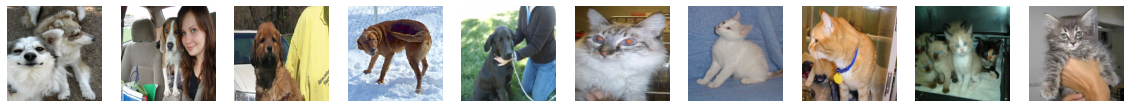

In [ ]:
_, axs = plt.subplots(1,10,figsize=(20,20))
for index, img_name in enumerate(os.listdir(TEST_PATH)):
  img_path = os.path.join(TEST_PATH, img_name)
  img = image.load_img(img_path, target_size=(224, 224))
  axs[index].grid('off')
  axs[index].axis('off')
  axs[index].imshow(img)
plt.show()

### Support functions for searching

In [ ]:
def get_image_from_index(image_number):
  for i, img in enumerate(os.listdir(TEST_PATH)):
    path = os.path.join(TEST_PATH, img)
    if i == image_number:
      img = image.load_img(path, target_size=(224, 224))
      plt.imshow(img)
      plt.title('Input image')
      return img

def search_image(img):
  img_data = image.img_to_array(img)
  # convert shape from (image_width, image_height, channel) to (1, image_width, image_height, channel)
  img_data = np.expand_dims(img_data, axis=0)
  # scale and resize
  img_data = preprocess_input(img_data)
  # extract feature using vgg16
  extracted_feature = model.predict(img_data)
  # convert from tensor to numpy array
  extracted_feature = np.array(extracted_feature)
  centroid = kmeans.predict(extracted_feature)
  print('Input image belong to centroid:', np.squeeze(centroid))
  print('5 similar images from centroid {}'.format(np.squeeze(centroid)))
  random = np.random.choice(np.where(kmeans.labels_ == np.squeeze(centroid))[0], 5)
  for i in random:
    plt.imshow(img_list[i].astype(np.uint8))
    plt.show()

### Choose an image randomly from the Test set to Search

Then, change the variable ``image_number`` to choose another picture.

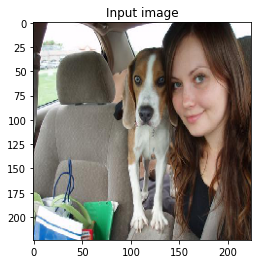

In [ ]:
image_number = 1
img = get_image_from_index(image_number)

### Search other images

Input image belong to centroid: 1
5 similar images from centroid 1


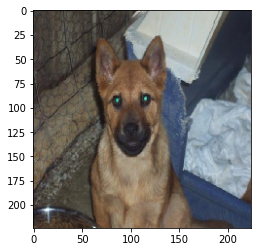

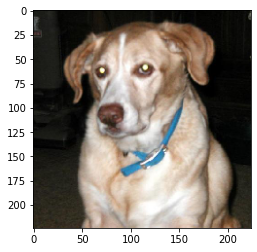

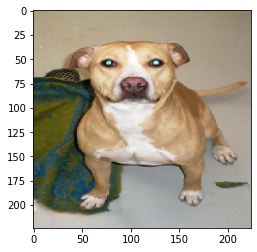

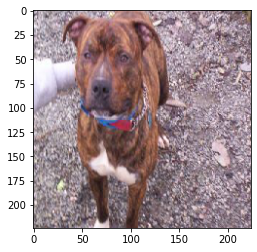

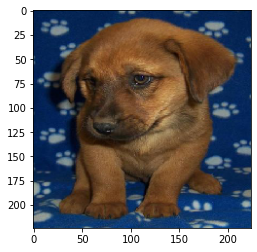

In [ ]:
search_image(img)